In [ ]:
"""
Analyze NN predictions. This is hacky code to get predictions to Claudio fast. 
Peter July 12 2023

Edited by Linnea September 13 2023
"""

import os
from collections import defaultdict
import numpy as np
import h5py
import matplotlib.pyplot as plt

import keras_core as keras

import tensorflow_io as tfio
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE

import sys
sys.path.append('../')
import preprocess.preprocess
import utils

%load_ext autoreload
%autoreload 2

2023-09-22 14:58:44.068247: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 14:58:44.134244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 14:58:44.983180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
# Create dataset object using IODataset
polarity = 'neg'
path = '/home/linneamw/sadow_lts/personal/linneamw/research/gcr/data/2023_07_01'
f_highquality = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed_training.h5'
f_lowquality = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed_training_lowquality.h5'
f_full = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed_training_full.h5'

# Load highquality data used for training/testing and split into train/test splits

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# N = 1000  # Just get a subset for testing
with h5py.File(f_highquality, 'r') as h5:
    print(h5.keys())
    
    num_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
    imodel  = h5['imodel'][:]
    ipar  = h5['ipar'][:]
    vseq  = h5['vseq'][:]
    quality  = h5['quality'][:]
    # num_samples = N
    # x = h5['/X_minmax'][:N, ...]
    # y = h5['Y_log_scaled'][:N,...]
x = tfio.IODataset.from_hdf5(f_highquality, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f_highquality, dataset='/Y_log_scaled')

# Split
# full = Dataset.from_tensor_slices((x, y))
full = Dataset.zip((x, y))
train = full.take(np.floor(num_samples *.9))#.repeat()
test = full.skip(np.floor(num_samples *.9))#.repeat()

# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)

# Some calcs
steps_per_epoch = int(num_samples * .9 / BATCH_SIZE )
validation_steps = int(num_samples * .1 / BATCH_SIZE)
print(f'Steps per epoch: {steps_per_epoch}')
print(f"Length of imodel: {len(imodel)}")
print(f"num_samples: {num_samples}")

<KeysViewHDF5 ['X', 'X_minmax', 'Y_log_scaled', 'imodel', 'ipar', 'quality', 'vseq']>


2023-09-22 14:58:46.880473: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-09-22 14:58:46.880628: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA
2023-09-22 14:58:47.046185: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Steps per epoch: 13975
Length of imodel: 1987658
num_samples: 1987658


In [3]:
# Load lowquality data NOT used training/testing

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
with h5py.File(f_lowquality, 'r') as h5:
    print(h5.keys())

    num_samples_lq, num_inputs_lq,  = h5['X_minmax'].shape
    
    imodel_lq  = h5['imodel'][:]
    ipar_lq  = h5['ipar'][:]
    vseq_lq  = h5['vseq'][:]
    quality_lq  = h5['quality'][:]

x_lq = tfio.IODataset.from_hdf5(f_lowquality, dataset='/X_minmax')

# Batch
BATCH_SIZE = 128
lowquality = x_lq.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)

# Some calcs
steps_per_epoch_lq = int(len(imodel_lq) / BATCH_SIZE )
print(f'Steps per epoch: {steps_per_epoch_lq}')
print(f"Length of lowquality data: {len(imodel_lq)}")
print(f"num_samples: {num_samples_lq}")

<KeysViewHDF5 ['X', 'X_minmax', 'imodel', 'ipar', 'quality', 'vseq']>
Steps per epoch: 6746
Length of lowquality data: 863542
num_samples: 863542


In [4]:
# Load model
model_version = 'v3.0'
model_path = f'../../models/model_{model_version}_{polarity}.keras'  # Must end with keras.
model = keras.models.load_model(model_path)

print(f"Model: {model_path}. Predicting...")

# Predict on the train and test sets
train_pred = model.predict(train, steps=steps_per_epoch+1)
test_pred = model.predict(test, steps=validation_steps+1)
lowquality_pred = model.predict(lowquality, steps=steps_per_epoch_lq+1)

# Untransform
train_pred = utils.untransform_output(train_pred)
test_pred = utils.untransform_output(test_pred)
lowquality_pred = utils.untransform_output(lowquality_pred)

Model: ../../models/model_v2.0_neg.keras. Predicting...
   82/13976 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step   

2023-09-22 14:58:47.699938: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2afe38027ba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-22 14:58:47.699965: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-22 14:58:47.735783: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13976/13976 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
6747/6747 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [5]:
# Combine train_pred and test_pred into one array, and create an array that is the same length 
# 1 if sample was from training, 0 if it was from test, and 2 if it was neither (low_quality)
pred = np.concatenate((train_pred, test_pred, lowquality_pred))
train_test_neither = np.concatenate((np.ones(len(train_pred)), np.zeros(len(test_pred)), np.zeros(len(lowquality_pred))+2))

# Concatenate the imodel, ipar, quality, and vseq arrays from normal and lq
imodel = np.concatenate((imodel, imodel_lq))
ipar = np.concatenate((ipar, ipar_lq))
vseq = np.concatenate((vseq, vseq_lq))
quality = np.concatenate((quality, quality_lq))

# Check shapes
print(f"Train_pred shape: {train_pred.shape}")
print(f"Test_pred shape: {test_pred.shape}")
print(f"Number of train_pred+test_pred: {len(train_pred)+len(test_pred)}")
print(f"Lowquality_pred shape: {lowquality_pred.shape}")
print(f"Train_test: {train_test_neither}")
print("\n\n")
print(f"Predictions shape: {pred.shape}")
print(f"Train_test shape: {train_test_neither.shape}")
print(f"Imodel shape: {imodel.shape}")
print(f"ipar shape: {ipar.shape}")
print(f"vseq shape: {vseq.shape}")
print(f"quality shape: {quality.shape}")

Train_pred shape: (1788892, 32)
Test_pred shape: (198766, 32)
Number of train_pred+test_pred: 1987658
Lowquality_pred shape: (863542, 32)
Train_test: [1. 1. 1. ... 2. 2. 2.]



Predictions shape: (2851200, 32)
Train_test shape: (2851200,)
Imodel shape: (2851200,)
ipar shape: (2851200,)
vseq shape: (2851200,)
quality shape: (2851200,)


In [6]:
# Create h5 file in model directory
model_dir = os.path.dirname(model_path)
h5_path = f'{model_dir}/predictions_{model_version}_{polarity}.h5'

print(f'Writing predictions to {h5_path}')
with h5py.File(h5_path, 'w') as predictions:
    predictions.create_dataset('predictions', data=pred)
    predictions.create_dataset('train_1_test_0_neither_2', data=train_test_neither)
    predictions.create_dataset('imodel', data=imodel)
    predictions.create_dataset('ipar', data=ipar)
    predictions.create_dataset('vseq', data=vseq)
    predictions.create_dataset('quality', data=quality)

Writing predictions to ../../models/predictions_v2.0_neg.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


TypeError: 'HDF5IODataset' object is not subscriptable

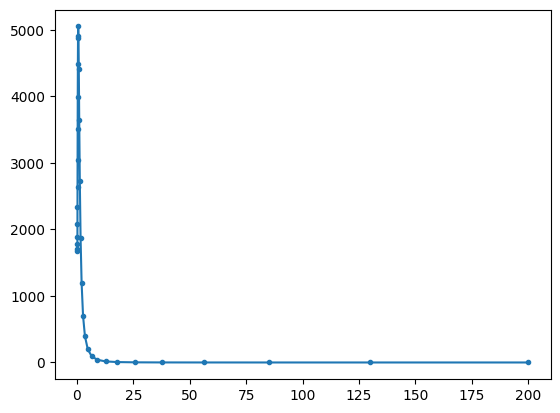

In [24]:
npi = train.as_numpy_iterator()
xbatch = npi.next()
yhat = model.predict(xbatch)

plt.plot(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(yhat[0,:]), marker='.', label='pred')
plt.plot(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(y[0,:]), marker='.', label='target')
plt.legend()

# plt.figure(2)
# plt.plot(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(yhat[0,:]), marker='.', label='pred')
# plt.plot(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(y[0,:]), marker='.', label='target')
# plt.legend()

# plt.figure(3)
# plt.loglog(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(yhat[0,:]), marker='.', label='pred')
# plt.loglog(preprocess.preprocess.RIGIDITY_VALS, utils.untransform_output(y[0,:]), marker='.', label='target')
# plt.legend()

In [ ]:
# Quick check of paredictions.
N = 1
print(yhat[:N, :])
print(Y[:N,:])
print(trainset[:N])
print(metadata['quality'][:N])
print(X_minmax[:N])


[[1.06897728e+02 1.09673195e+02 1.16209541e+02 1.25315056e+02
  1.43295715e+02 1.67029953e+02 1.98731354e+02 2.46567688e+02
  3.09029297e+02 3.91782898e+02 5.04324951e+02 6.44143311e+02
  8.05205566e+02 9.85203247e+02 1.13972607e+03 1.21198193e+03
  1.14415308e+03 9.44869263e+02 6.86349426e+02 4.37492035e+02
  2.58357605e+02 1.33430969e+02 6.42946243e+01 2.77195663e+01
  1.08660107e+01 4.18909931e+00 1.51157510e+00 5.27836978e-01
  1.73729241e-01 5.68317994e-02 1.76857505e-02 6.50129607e-03]]
[[1.08284531e+02 1.11323494e+02 1.17628922e+02 1.27677155e+02
  1.46093491e+02 1.71169281e+02 2.04915222e+02 2.56114258e+02
  3.24251160e+02 4.13785675e+02 5.39576233e+02 6.97150818e+02
  8.83545288e+02 1.09432202e+03 1.27094714e+03 1.34427783e+03
  1.25773022e+03 1.02853918e+03 7.46904968e+02 4.77308441e+02
  2.84326569e+02 1.48361359e+02 7.23004379e+01 3.14299583e+01
  1.23511438e+01 4.74311495e+00 1.69762433e+00 5.87181091e-01
  1.90945834e-01 6.02606162e-02 1.84793100e-02 6.50727283e-03]]
[ Tr

(array([    0.,  2023., 31535., 34441., 20392.]),
 array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <BarContainer object of 5 artists>)

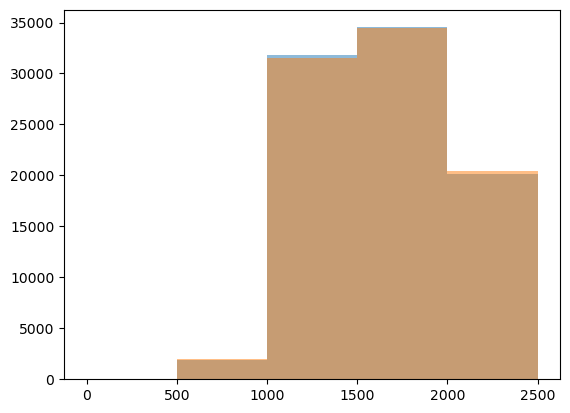

In [ ]:
import matplotlib.pyplot as plt
N = 100000
i=16
bins = np.arange(0, 3000, 500)
plt.hist(yhat[:N, i], bins=bins, alpha=0.5,  label='pred')
plt.hist(Y[:N, i], bins=bins, alpha=0.5, label='true')

In [ ]:
yhat.shape

(2851200, 32)

In [ ]:
yhat[0, :N].shape

(32,)